# Import

In [59]:
import os
import sys

import time
import json
import math
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import cv2.aruco as aruco

import pytransform3d
import pytransform3d.camera as pc
import pytransform3d.transformations as pt
from pytransform3d.urdf import UrdfTransformManager
from pytransform3d.plot_utils import make_3d_axis, plot_vector
from urdf_parser_py.urdf import URDF

import itertools
from scipy.optimize import minimize, least_squares

# Helper Functions

In [2]:
%matplotlib widget

def load_json(filename: str):
    # Construct the absolute path by joining the current directory and relative path
    absolute_path = os.path.join(os.getcwd(), '..', filename)
    # Load the JSON data
    with open(absolute_path, 'r') as file:
        json_data = json.load(file)    
    return json_data

def xml_to_str(robot):
    # To XML string with filtering
    temp_str = robot.to_xml_string()
    words = temp_str.split()
    words[5] = '>'
    urdf_str = ' '.join(words)
    return urdf_str

def motor_cmd_joint(cmd_lnp,cmd_lnt,cmd_unt,cmd_et,cmd_lep,cmd_rep):  # degrees
    cmd_lnp = math.radians(cmd_lnp)
    cmd_lnt = math.radians(cmd_lnt)
    cmd_unt = math.radians(cmd_unt)
    cmd_et = math.radians(cmd_et)
    cmd_lep = math.radians(cmd_lep)
    cmd_rep = math.radians(cmd_rep)

    neck_pitch = cmd_lnt*0.5 + 0
    neck_yaw = cmd_lnp*0.5 + 0
    head_pitch = cmd_unt*0.5 + 0
    eyes_pitch = cmd_et*0.4 + 0
    lefteye_yaw = cmd_lep*1.6 + 0
    righteye_yaw = cmd_rep*1.7 + 0

    res_dict = {
        "neck_pitch": neck_pitch,
        "neck_yaw": neck_yaw,
        "head_pitch": head_pitch,
        "eyes_pitch": eyes_pitch,
        "lefteye_yaw": lefteye_yaw,
        "righteye_yaw": righteye_yaw,
    }

    return res_dict

def generate_chest_dataset(mat, z, x_prime, y_prime): # Opencv coordinates
    a = np.array([[mat[0,0],mat[0,1],-x_prime],
              [mat[1,0],mat[1,1],-y_prime],
              [mat[2,0],mat[2,1],-1]])
    b = np.array([-mat[0,2]*z-mat[0,3], -mat[1,2]*z-mat[1,3], -mat[2,2]*z-mat[2,3]])
    x = np.linalg.solve(a, b)
    return np.append(x[:2],z)

# Initialization

In [3]:
# Load Configs
cam_mtxs = load_json('camera_mtx.json')
gaze_ctrs = load_json('calib_params.json')
urdf_path = os.path.join(os.getcwd(),"..","urdf","chest_grace_cam_true.urdf")
robot = URDF.from_xml_file(urdf_path)

In [4]:
# Load CSV Optimization Results

fit_result = "20241005_152748_279760_71552_075m_grace_results.csv"
data_dir = "thesis"
csv_path = os.path.join(os.getcwd(),"..","results",data_dir,fit_result)
csv_df = pd.read_csv(csv_path, index_col=0)
var_dict = dict(zip(csv_df.index,csv_df['learned'].values))

In [5]:
# Decision Variables 
var_list = list(var_dict.values())

# Variable Names
var_names_list = list(var_dict.keys())

# Mapping
idx2var = dict(zip(list(range(len(var_names_list))),var_names_list))
var2idx = dict(zip(var_names_list, list(range(len(var_names_list)))))

# Variable Assignment
V = np.array(var_list)

In [6]:
# URDF Variable Assignment
for joint in robot.joints:
    if joint.name == 'torso':
        joint.origin.position[0] = V[var2idx['torso_origin_x']]
        joint.origin.position[1] = V[var2idx['torso_origin_y']]
        joint.origin.position[2] = V[var2idx['torso_origin_z']]
    elif joint.name == 'neck_pitch':
        joint.origin.rotation[0] = V[var2idx['neck_pitch_rot_r']]
    elif joint.name == 'head_pitch':
        joint.origin.position[2] = V[var2idx['head_pitch_origin_z']]
    elif joint.name == 'eyes_pitch':
        joint.origin.position[0] = V[var2idx['eyes_pitch_origin_x']]
        joint.origin.position[2] = V[var2idx['eyes_pitch_origin_z']]
    elif joint.name == 'lefteye_yaw':
        joint.origin.position[1] = V[var2idx['lefteye_yaw_origin_y']]
    elif joint.name == 'righteye_yaw':
        joint.origin.position[1] = -V[var2idx['lefteye_yaw_origin_y']]
    elif joint.name == 'lefteye_cam':
        joint.origin.position[0] = V[var2idx['lefteye_cam_origin_x']]
        joint.origin.rotation[0] = V[var2idx['lefteye_cam_rot_r']]
        joint.origin.rotation[2] = V[var2idx['lefteye_cam_rot_y']]
    elif joint.name == 'righteye_cam':
        joint.origin.position[0] = V[var2idx['righteye_cam_origin_x']]
        joint.origin.rotation[0] = V[var2idx['righteye_cam_rot_r']]
        joint.origin.rotation[2] = V[var2idx['righteye_cam_rot_y']]
        
# XML to String
urdf_str = xml_to_str(robot)

# Transform Manager
tm = UrdfTransformManager()
tm.load_urdf(urdf_str)

# Single Pass

In [7]:
# Input (rad)

cmd_lnt = math.radians(0)
cmd_lnp = math.radians(0)
cmd_unt = math.radians(0)
cmd_et = math.radians(0)
cmd_lep = math.radians(0)
cmd_rep = math.radians(0)

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)

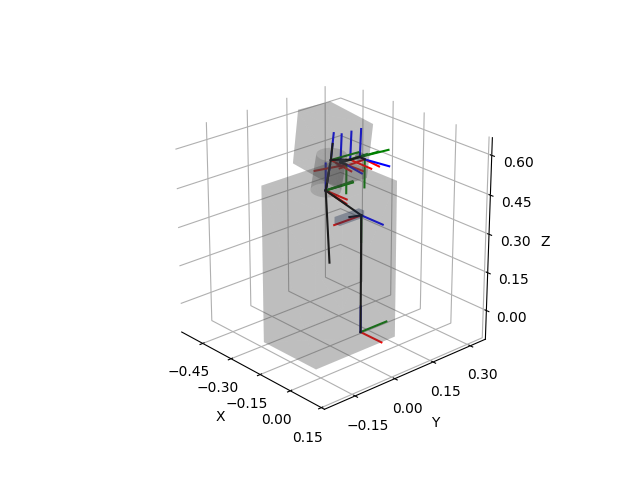

In [8]:
# Visualize
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
joints_list = ["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"]
ax = tm.plot_frames_in("world", whitelist=joints_list,
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)
ax = tm.plot_visuals("world", alpha=0.2)
ax.set_xlim([-0.55, 0.15])
ax.set_ylim([-0.25, 0.35])
ax.set_zlim([-0.1, 0.65])
ax.view_init(elev=24, azim=-42, roll=0)
plt.show()

# Camera Angle Rotation Offset

## Original Undistort Points

In [9]:
# Gaze Centers

og_left_gaze_pt_x = gaze_ctrs['left_eye']['x_center']
og_left_gaze_pt_y = gaze_ctrs['left_eye']['y_center']
og_right_gaze_pt_x = gaze_ctrs['right_eye']['x_center']
og_right_gaze_pt_y = gaze_ctrs['right_eye']['y_center']
print("og_left_gaze_pt_x:", og_left_gaze_pt_x)
print("og_left_gaze_pt_y:", og_left_gaze_pt_y)
print("og_right_gaze_pt_x:", og_right_gaze_pt_x)
print("og_right_gaze_pt_y:", og_right_gaze_pt_y)

og_left_gaze_pt_x: 411
og_left_gaze_pt_y: 235
og_right_gaze_pt_x: 151
og_right_gaze_pt_y: 246


In [10]:
# Normalized Point (z=1.0)
og_left_undistort_pts = cv2.undistortPoints((og_left_gaze_pt_x, og_left_gaze_pt_y), 
                                         np.array(cam_mtxs['left_eye']['camera_matrix']), 
                                         np.array(cam_mtxs['left_eye']['distortion_coefficients']))
og_right_undistort_pts = cv2.undistortPoints((og_right_gaze_pt_x, og_right_gaze_pt_y), 
                                          np.array(cam_mtxs['right_eye']['camera_matrix']), 
                                          np.array(cam_mtxs['right_eye']['distortion_coefficients']))
print('og_left_undistort_pts:', og_left_undistort_pts)  # For Y, Downwards is + because of Camera Opencv Coordinate System
print('og_right_undistort_pts:', og_right_undistort_pts)  # For Y, Downwards is + because of Camera Opencv Coordinate System

og_left_undistort_pts: [[[0.19142607 0.03459041]]]
og_right_undistort_pts: [[[-0.2600561   0.05559228]]]


In [11]:
# Undistored Points

og_left_x_prime = og_left_undistort_pts.squeeze()[0]
og_left_y_prime = og_left_undistort_pts.squeeze()[1]
og_right_x_prime = og_right_undistort_pts.squeeze()[0]
og_right_y_prime = og_right_undistort_pts.squeeze()[1]

print('og_left_x_prime:',og_left_x_prime)
print('og_left_y_prime:',og_left_y_prime)
print('og_right_x_prime:',og_right_x_prime)
print('og_right_y_prime:',og_right_y_prime)

og_left_x_prime: 0.19142607185001126
og_left_y_prime: 0.034590406011504184
og_right_x_prime: -0.26005610414060365
og_right_y_prime: 0.055592279312658976


In [12]:
# Checking of Undistortion
og_left_pixels,_ = cv2.projectPoints((og_left_undistort_pts.squeeze()[0], og_left_undistort_pts.squeeze()[1], 1.0), 
                                np.array([0.0,0.0,0.0]), np.array([0.0,0.0,0.0]), 
                                  np.array(cam_mtxs['left_eye']['camera_matrix']), 
                                  np.array(cam_mtxs['left_eye']['distortion_coefficients']))
og_right_pixels,_ = cv2.projectPoints((og_right_undistort_pts.squeeze()[0], og_right_undistort_pts.squeeze()[1], 1.0), 
                                 np.array([0.0,0.0,0.0]), np.array([0.0,0.0,0.0]), 
                                  np.array(cam_mtxs['right_eye']['camera_matrix']), 
                                  np.array(cam_mtxs['right_eye']['distortion_coefficients']))
print('og_left_pixels:', og_left_pixels)
print('og_right_pixels:',og_right_pixels)

og_left_pixels: [[[411. 235.]]]
og_right_pixels: [[[151.00000002 246.        ]]]


In [13]:
# Angle Offset
og_left_yaw_offset = math.atan2(og_left_undistort_pts.squeeze()[0],1.0)  # radians unit
og_left_pitch_offset = math.atan2(og_left_undistort_pts.squeeze()[1],1.0) # For Y, Downwards is + because of Camera Opencv Coordinate System
og_right_yaw_offset = math.atan2(og_right_undistort_pts.squeeze()[0],1.0) 
og_right_pitch_offset = math.atan2(og_right_undistort_pts.squeeze()[1],1.0) # For Y, Downwards is + because of Camera Opencv Coordinate System

print('og_left_yaw_offset(rad):', og_left_yaw_offset)
print('og_left_pitch_offset(rad)(opencv coord):', og_left_pitch_offset)
print('og_right_yaw_offset:(rad)', og_right_yaw_offset)
print('og_right_pitch_offset(rad)(opencv coord):', og_right_pitch_offset)
print('-----')

print('og_left_yaw_offset(deg):', math.degrees(og_left_yaw_offset))
print('og_left_pitch_offset(deg)(opencv coord):', math.degrees(og_left_pitch_offset))
print('og_right_yaw_offset(deg):', math.degrees(og_right_yaw_offset))
print('og_right_pitch_offset(deg)(opencv coord):', math.degrees(og_right_pitch_offset))

og_left_yaw_offset(rad): 0.18913797017088096
og_left_pitch_offset(rad)(opencv coord): 0.03457662014401592
og_right_yaw_offset:(rad) -0.2544206094843146
og_right_pitch_offset(rad)(opencv coord): 0.05553511593216458
-----
og_left_yaw_offset(deg): 10.836807436462736
og_left_pitch_offset(deg)(opencv coord): 1.981094404079137
og_right_yaw_offset(deg): -14.57722714459731
og_right_pitch_offset(deg)(opencv coord): 3.1819277576827667


## New Undistort Points

In [14]:
# Angle Offset

left_pitch_offset =  V[var2idx['lefteye_cam_rot_r']] + math.pi/2
left_yaw_offset =  V[var2idx['lefteye_cam_rot_y']] + math.pi/2
right_pitch_offset =  V[var2idx['righteye_cam_rot_r']] + math.pi/2
right_yaw_offset =  V[var2idx['righteye_cam_rot_y']] + math.pi/2

print('og_left_pitch_offset(rad)(opencv coord):', og_left_pitch_offset)
print('og_left_yaw_offset(rad):', og_left_yaw_offset)
print('og_right_pitch_offset(rad)(opencv coord):', og_right_pitch_offset)
print('og_right_yaw_offset:(rad)', og_right_yaw_offset)

print('-----')

print('left_pitch_offset(rad)(opencv coord):', left_pitch_offset)
print('left_yaw_offset(rad):', left_yaw_offset)
print('right_pitch_offset(rad)(opencv coord):', right_pitch_offset)
print('right_yaw_offset:(rad)', right_yaw_offset)

og_left_pitch_offset(rad)(opencv coord): 0.03457662014401592
og_left_yaw_offset(rad): 0.18913797017088096
og_right_pitch_offset(rad)(opencv coord): 0.05553511593216458
og_right_yaw_offset:(rad) -0.2544206094843146
-----
left_pitch_offset(rad)(opencv coord): 0.03869824008382294
left_yaw_offset(rad): 0.19055362100197382
right_pitch_offset(rad)(opencv coord): 0.06472766343170466
right_yaw_offset:(rad) -0.25204527016734346


In [15]:
left_x_prime = math.tan(left_yaw_offset)
left_y_prime = math.tan(left_pitch_offset)
right_x_prime = math.tan(right_yaw_offset)
right_y_prime = math.tan(right_pitch_offset)

print('og_left_x_prime:',og_left_x_prime)
print('og_left_y_prime:',og_left_y_prime)
print('og_right_x_prime:',og_right_x_prime)
print('og_right_y_prime:',og_right_y_prime)

print('-----')

print('left_x_prime:',left_x_prime)
print('left_y_prime:',left_y_prime)
print('right_x_prime:',right_x_prime)
print('right_y_prime:',right_y_prime)

og_left_x_prime: 0.19142607185001126
og_left_y_prime: 0.034590406011504184
og_right_x_prime: -0.26005610414060365
og_right_y_prime: 0.055592279312658976
-----
left_x_prime: 0.1928939964837528
left_y_prime: 0.038717569227789614
right_x_prime: -0.2575216833793788
right_y_prime: 0.06481821103938706


In [16]:
# Checking of Undistortion
left_pixels,_ = cv2.projectPoints((left_x_prime, left_y_prime, 1.0), 
                                np.array([0.0,0.0,0.0]), np.array([0.0,0.0,0.0]), 
                                  np.array(cam_mtxs['left_eye']['camera_matrix']), 
                                  np.array(cam_mtxs['left_eye']['distortion_coefficients']))
right_pixels,_ = cv2.projectPoints((right_x_prime, right_y_prime, 1.0), 
                                 np.array([0.0,0.0,0.0]), np.array([0.0,0.0,0.0]), 
                                  np.array(cam_mtxs['right_eye']['camera_matrix']), 
                                  np.array(cam_mtxs['right_eye']['distortion_coefficients']))

print('og_left_pixels:', og_left_pixels)
print('og_right_pixels:',og_right_pixels)

print('-----')

print('left_pixels:', left_pixels)
print('right_pixels:', right_pixels)

og_left_pixels: [[[411. 235.]]]
og_right_pixels: [[[151.00000002 246.        ]]]
-----
left_pixels: [[[411.83620817 237.33684899]]]
right_pixels: [[[152.49851915 251.32199021]]]


# Plotting

## Left Basic Axes

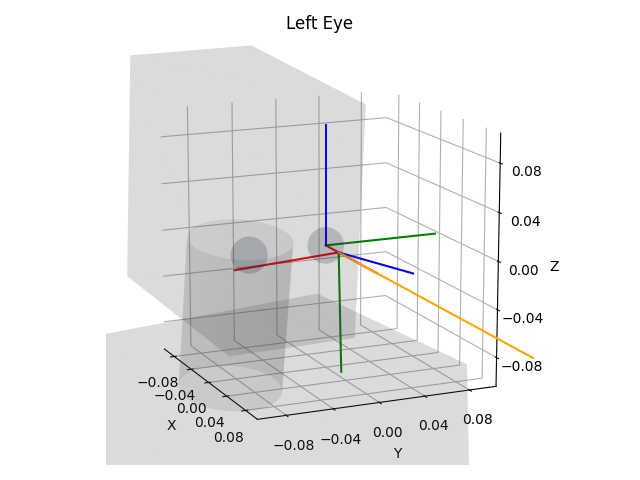

In [17]:
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in("lefteye", whitelist=['lefteye','leftcamera'],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_visuals("lefteye", alpha=0.1)
T_lprimel = tm.get_transform('leftcamera','lefteye')
left_gaze_pts_l = (T_lprimel @ np.array([left_x_prime, left_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()

ax.plot([T_lprimel[0,3],left_gaze_pts_l[0]],[T_lprimel[1,3],left_gaze_pts_l[1]],[T_lprimel[2,3],left_gaze_pts_l[2]], color="orange")
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.1, 0.1])
ax.set_zlim([-0.1, 0.1])
ax.view_init(elev=14, azim=-24, roll=0)
ax.set_title('Left Eye')
plt.tight_layout()

## Basic Right Axes

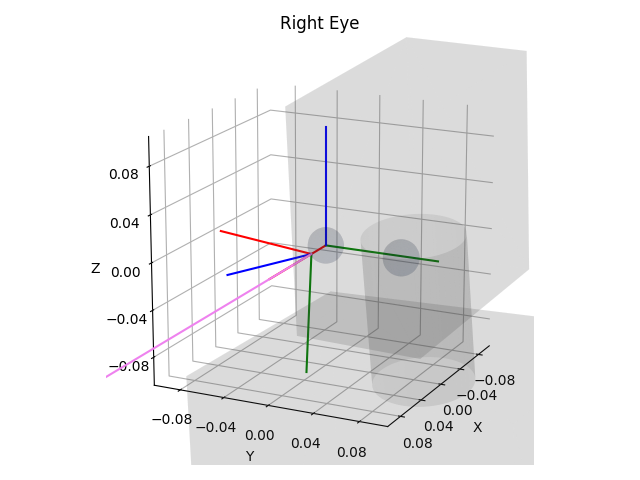

In [18]:
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in("righteye", whitelist=['righteye','rightcamera'],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_visuals("righteye", alpha=0.1)
T_rprimer = tm.get_transform('rightcamera','righteye')
right_gaze_pts_r = (T_rprimer @ np.array([right_x_prime, right_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()

ax.plot([T_rprimer[0,3],right_gaze_pts_r[0]],[T_rprimer[1,3],right_gaze_pts_r[1]],[T_rprimer[2,3],right_gaze_pts_r[2]], color="violet")
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.1, 0.1])
ax.set_zlim([-0.1, 0.1])
ax.view_init(elev=17, azim=26, roll=0)
ax.set_title('Right Eye')
plt.tight_layout()

## Plot Left and Right Eye

In [19]:
# Input (rad)

cmd_lnt = 0
cmd_lnp = 0
cmd_unt = 0
cmd_et = 0
cmd_lep = math.radians(5)
cmd_rep = math.radians(5)

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)

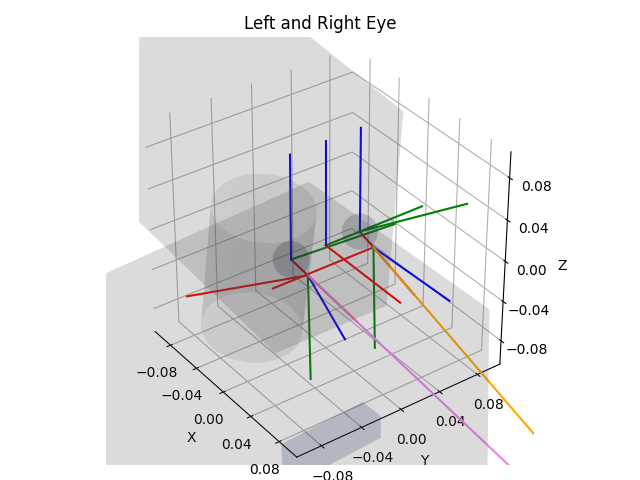

In [20]:
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in('eyes', whitelist=['eyes','lefteye','leftcamera','righteye','rightcamera'],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_visuals("eyes", alpha=0.1)
T_lprimel = tm.get_transform('leftcamera', 'eyes')
left_gaze_pts_l = (T_lprimel @ np.array([left_x_prime, left_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()
T_rprimer = tm.get_transform('rightcamera', 'eyes')
right_gaze_pts_r = (T_rprimer @ np.array([right_x_prime, right_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()

ax.plot([T_lprimel[0,3],left_gaze_pts_l[0]],[T_lprimel[1,3],left_gaze_pts_l[1]],[T_lprimel[2,3],left_gaze_pts_l[2]], color="orange")
ax.plot([T_rprimer[0,3],right_gaze_pts_r[0]],[T_rprimer[1,3],right_gaze_pts_r[1]],[T_rprimer[2,3],right_gaze_pts_r[2]], color="violet")
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.1, 0.1])
ax.set_zlim([-0.1, 0.1])
ax.view_init(elev=34, azim=-36, roll=0)
ax.set_title('Left and Right Eye')
plt.tight_layout()

## Plot with Whole Robot

In [21]:
# Input (rad)

cmd_lnt = math.radians(5)
cmd_lnp = math.radians(5)
cmd_unt = math.radians(5)
cmd_et = math.radians(5)
cmd_lep = math.radians(5)
cmd_rep = math.radians(5)

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)

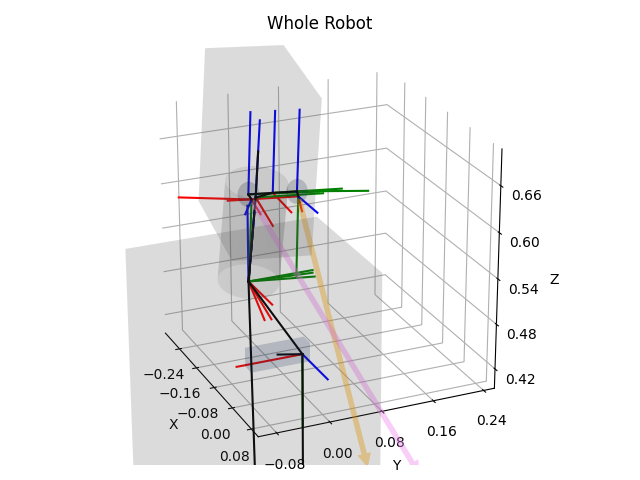

In [22]:
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in('world', whitelist=["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)
ax = tm.plot_visuals("world", alpha=0.1)
T_lprimel = tm.get_transform('leftcamera', 'world')
left_gaze_pts_l = (T_lprimel @ np.array([left_x_prime, left_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()
T_rprimer = tm.get_transform('rightcamera', 'world')
right_gaze_pts_r = (T_rprimer @ np.array([right_x_prime, right_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()

# Left Gaze
plot_vector(
    start=np.array([T_lprimel[0,3], T_lprimel[1,3], T_lprimel[2,3]]),
    direction=np.array([left_gaze_pts_l[0]-T_lprimel[0,3], left_gaze_pts_l[1]-T_lprimel[1,3], left_gaze_pts_l[2]-T_lprimel[2,3]]),
    s=1.0,
    lw=0,  # Remove line around arrow
    color='orange',
    alpha=0.4
)
# Right Gaze
plot_vector(
    start=np.array([T_rprimer[0,3], T_rprimer[1,3], T_rprimer[2,3]]),
    direction=np.array([right_gaze_pts_r[0]-T_rprimer[0,3], right_gaze_pts_r[1]-T_rprimer[1,3], right_gaze_pts_r[2]-T_rprimer[2,3]]),
    s=1.0,
    lw=0,  # Remove line around arrow
    color='violet',
    alpha=0.4
)

ax.view_init(elev=23, azim=-24, roll=0)
ax.set_xlim([-0.3, 0.1])
ax.set_ylim([-0.1, 0.25])
ax.set_zlim([0.4, 0.7])
ax.set_title('Whole Robot')
plt.tight_layout()

# Dataset Generation with Robot Gaze Plotting

In [23]:
# Input (rad)

cmd_lnt = math.radians(0)
cmd_lnp = math.radians(0)
cmd_unt = math.radians(0)
cmd_et = math.radians(0)
cmd_lep = math.radians(0)
cmd_rep = math.radians(0)

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)

In [24]:
# Depth
z_depth = 1.0 # meters

# Get Transform
T_clprime = tm.get_transform('realsense','leftcamera')   # Opencv coords
T_crprime = tm.get_transform('realsense','rightcamera')   # Opencv coords

# Get Camera Chest Points
X_C_L = generate_chest_dataset(mat=T_clprime, z=z_depth, x_prime=left_x_prime, y_prime=left_y_prime)
X_C_R = generate_chest_dataset(mat=T_crprime, z=z_depth, x_prime=right_x_prime, y_prime=right_y_prime)
print('T_clprime:',T_clprime)
print('T_crprime:',T_crprime)
print('X_C_L:',X_C_L)
print('X_C_R:',X_C_R)

T_clprime: [[ 0.99415298 -0.04004038  0.10028273 -0.01202186]
 [ 0.03633676  0.99859807  0.03849066  0.21118227]
 [-0.10168333 -0.03462165  0.99421418 -0.02387733]
 [ 0.          0.          0.          1.        ]]
T_crprime: [[ 0.97577309 -0.03930102 -0.21522617 -0.07155881]
 [ 0.05406935  0.99653743  0.0631637   0.20942295]
 [ 0.21199854 -0.07327058  0.97451939 -0.04581674]
 [ 0.          0.          0.          1.        ]]
X_C_L: [ 0.09046758 -0.21576057  1.        ]
X_C_R: [ 0.0341675  -0.21349302  1.        ]


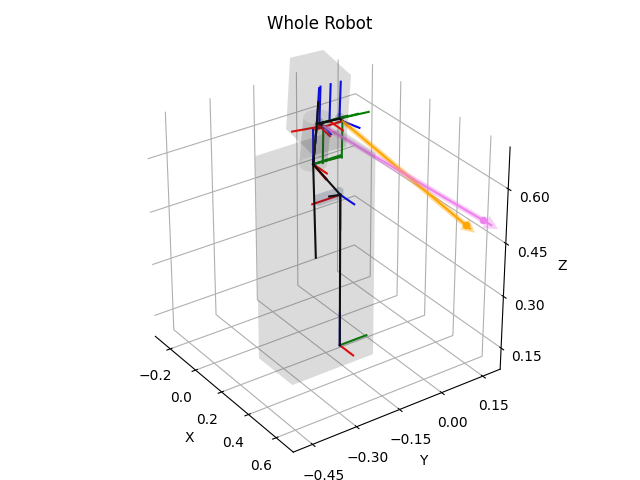

In [25]:
# Plotting

plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in('world', whitelist=["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)
ax = tm.plot_visuals("world", alpha=0.1)

#  Gaze Vectors
T_lprimel = tm.get_transform('leftcamera', 'world')
left_gaze_pts_l = (T_lprimel @ np.array([left_x_prime, left_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()
T_rprimer = tm.get_transform('rightcamera', 'world')
right_gaze_pts_r = (T_rprimer @ np.array([right_x_prime, right_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()
# Left Gaze
plot_vector(
    start=np.array([T_lprimel[0,3], T_lprimel[1,3], T_lprimel[2,3]]),
    direction=np.array([left_gaze_pts_l[0]-T_lprimel[0,3], left_gaze_pts_l[1]-T_lprimel[1,3], left_gaze_pts_l[2]-T_lprimel[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='orange',
    alpha=0.4
)
ax.plot([T_lprimel[0,3],left_gaze_pts_l[0]],[T_lprimel[1,3],left_gaze_pts_l[1]],[T_lprimel[2,3],left_gaze_pts_l[2]], color='orange')
# Right Gaze
plot_vector(
    start=np.array([T_rprimer[0,3], T_rprimer[1,3], T_rprimer[2,3]]),
    direction=np.array([right_gaze_pts_r[0]-T_rprimer[0,3], right_gaze_pts_r[1]-T_rprimer[1,3], right_gaze_pts_r[2]-T_rprimer[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='violet',
    alpha=0.4
)
ax.plot([T_rprimer[0,3],right_gaze_pts_r[0]],[T_rprimer[1,3],right_gaze_pts_r[1]],[T_rprimer[2,3],right_gaze_pts_r[2]], color='violet')

# Plot Points
T_cworld = tm.get_transform('realsense', 'world')
left_target_pts = (T_cworld @ np.array([X_C_L[0], X_C_L[1], X_C_L[2], 1.0]).reshape(-1,1)).squeeze()
right_target_pts = (T_cworld @ np.array([X_C_R[0], X_C_R[1], X_C_R[2], 1.0]).reshape(-1,1)).squeeze()
ax.scatter([left_target_pts[0]],[left_target_pts[1]],[left_target_pts[2]], color='orange')
ax.scatter([right_target_pts[0]],[right_target_pts[1]],[right_target_pts[2]], color='violet')

ax.view_init(elev=30, azim=-35, roll=0)
ax.set_xlim([-0.3, 0.7])
ax.set_ylim([-0.5, 0.2])
ax.set_zlim([0.1, 0.7])
ax.set_title('Whole Robot')
plt.tight_layout()

# Axis Vectors

In [26]:
# X-Axis Point for Plotting Left and Right Vectors
T_lw = tm.get_transform('lefteye','world')
x_lw = (T_lw @ np.array([1.0, 0, 0, 1.0]).reshape(-1,1)).squeeze()

T_rw = tm.get_transform('righteye','world')
x_rw = (T_rw @ np.array([1.0, 0, 0, 1.0]).reshape(-1,1)).squeeze()

print('x_lw:', x_lw)
print('x_rw:', x_rw)

x_lw: [ 0.98717637 -0.08945143  0.66310591  1.        ]
x_rw: [ 0.98889428 -0.03406314  0.66087507  1.        ]


In [27]:
# X-Axis Vector
v_lw = np.array([x_lw[0]-T_lw[0,3], x_lw[1]-T_lw[1,3], x_lw[2]-T_lw[2,3]])
v_rw = np.array([x_rw[0]-T_rw[0,3], x_rw[1]-T_rw[1,3], x_rw[2]-T_rw[2,3]])

print('v_lw:',v_lw)
print('v_rw:',v_rw)

v_lw: [ 0.99594324 -0.08991105  0.00361458]
v_rw: [ 0.99938342  0.03508239 -0.0014197 ]


In [28]:
# Checking the Unit Vector
u_lw = v_lw/np.linalg.norm(v_lw)
u_rw = v_rw/np.linalg.norm(v_rw)

print('u_lw:',u_lw)
print('u_rw:',u_rw)

u_lw: [ 0.99594324 -0.08991105  0.00361458]
u_rw: [ 0.99938342  0.03508239 -0.0014197 ]


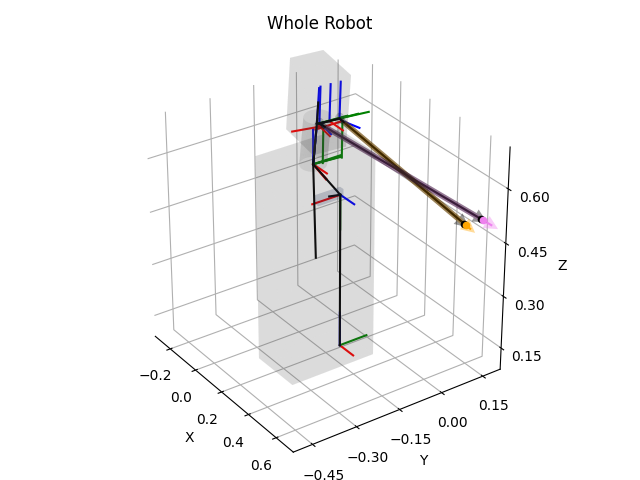

In [29]:
# Input (rad)

cmd_lnt = math.radians(0)
cmd_lnp = math.radians(0)
cmd_unt = math.radians(0)
cmd_et = math.radians(0)
cmd_lep = math.radians(0)
cmd_rep = math.radians(0)

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)


# Depth
z_depth = 1.0 # meters

# Get Transform
T_clprime = tm.get_transform('realsense','leftcamera')   # Opencv coords
T_crprime = tm.get_transform('realsense','rightcamera')   # Opencv coords

# Get Camera Chest Points
X_C_L = generate_chest_dataset(mat=T_clprime, z=z_depth, x_prime=left_x_prime, y_prime=left_y_prime)
X_C_R = generate_chest_dataset(mat=T_crprime, z=z_depth, x_prime=right_x_prime, y_prime=right_y_prime)


# Plotting
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in('world', whitelist=["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)
ax = tm.plot_visuals("world", alpha=0.1)

#  Gaze Vectors
T_lprimel = tm.get_transform('leftcamera', 'world')
left_gaze_pts_l = (T_lprimel @ np.array([left_x_prime, left_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()
T_rprimer = tm.get_transform('rightcamera', 'world')
right_gaze_pts_r = (T_rprimer @ np.array([right_x_prime, right_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()

# Left Gaze from Camera
plot_vector(
    start=np.array([T_lprimel[0,3], T_lprimel[1,3], T_lprimel[2,3]]),
    direction=np.array([left_gaze_pts_l[0]-T_lprimel[0,3], left_gaze_pts_l[1]-T_lprimel[1,3], left_gaze_pts_l[2]-T_lprimel[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='orange',
    alpha=0.4
)
ax.plot([T_lprimel[0,3],left_gaze_pts_l[0]],[T_lprimel[1,3],left_gaze_pts_l[1]],[T_lprimel[2,3],left_gaze_pts_l[2]], color='orange')

# Right Gaze from Camera
plot_vector(
    start=np.array([T_rprimer[0,3], T_rprimer[1,3], T_rprimer[2,3]]),
    direction=np.array([right_gaze_pts_r[0]-T_rprimer[0,3], right_gaze_pts_r[1]-T_rprimer[1,3], right_gaze_pts_r[2]-T_rprimer[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='violet',
    alpha=0.4
)
ax.plot([T_rprimer[0,3],right_gaze_pts_r[0]],[T_rprimer[1,3],right_gaze_pts_r[1]],[T_rprimer[2,3],right_gaze_pts_r[2]], color='violet')

# Plot Points from Camera
T_cworld = tm.get_transform('realsense', 'world')
left_target_pts = (T_cworld @ np.array([X_C_L[0], X_C_L[1], X_C_L[2], 1.0]).reshape(-1,1)).squeeze()
right_target_pts = (T_cworld @ np.array([X_C_R[0], X_C_R[1], X_C_R[2], 1.0]).reshape(-1,1)).squeeze()
ax.scatter([left_target_pts[0]],[left_target_pts[1]],[left_target_pts[2]], color='orange')
ax.scatter([right_target_pts[0]],[right_target_pts[1]],[right_target_pts[2]], color='violet')

# Left Gaze from Left Eye
plot_vector(
    start=np.array([T_lw[0,3], T_lw[1,3], T_lw[2,3]]),
    direction=v_lw,
    s=1.05,
    lw=0,  # Remove line around arrow
    color='black',
    alpha=0.4
)
ax.plot([T_lw[0,3],x_lw[0]],[T_lw[1,3],x_lw[1]],[T_lw[2,3],x_lw[2]], color='black')
ax.scatter([x_lw[0]],[x_lw[1]],[x_lw[2]], color='black')

# Right Gaze from Right Eye
plot_vector(
    start=np.array([T_rw[0,3], T_rw[1,3], T_rw[2,3]]),
    direction=v_rw,
    s=1.05,
    lw=0,  # Remove line around arrow
    color='black',
    alpha=0.4
)
ax.plot([T_rw[0,3],x_rw[0]],[T_rw[1,3],x_rw[1]],[T_rw[2,3],x_rw[2]], color='black')
ax.scatter([x_rw[0]],[x_rw[1]],[x_rw[2]], color='black')


ax.view_init(elev=30, azim=-35, roll=0)
ax.set_xlim([-0.3, 0.7])
ax.set_ylim([-0.5, 0.2])
ax.set_zlim([0.1, 0.7])
ax.set_title('Whole Robot')
plt.tight_layout()

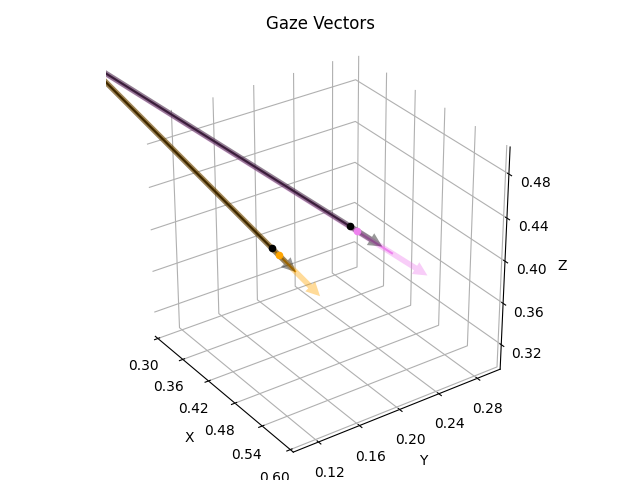

In [30]:
# Input (rad)

cmd_lnt = math.radians(0)
cmd_lnp = math.radians(0)
cmd_unt = math.radians(0)
cmd_et = math.radians(0)
cmd_lep = math.radians(0)
cmd_rep = math.radians(0)

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)


# Depth
z_depth = 1.0 # meters

# Get Transform
T_clprime = tm.get_transform('realsense','leftcamera')   # Opencv coords
T_crprime = tm.get_transform('realsense','rightcamera')   # Opencv coords

# Get Camera Chest Points
X_C_L = generate_chest_dataset(mat=T_clprime, z=z_depth, x_prime=left_x_prime, y_prime=left_y_prime)
X_C_R = generate_chest_dataset(mat=T_crprime, z=z_depth, x_prime=right_x_prime, y_prime=right_y_prime)


# Plotting
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in('world', whitelist=["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)
ax = tm.plot_visuals("world", alpha=0.1)

#  Gaze Vectors
T_lprimel = tm.get_transform('leftcamera', 'world')
left_gaze_pts_l = (T_lprimel @ np.array([left_x_prime, left_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()
T_rprimer = tm.get_transform('rightcamera', 'world')
right_gaze_pts_r = (T_rprimer @ np.array([right_x_prime, right_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()

# Left Gaze from Camera
plot_vector(
    start=np.array([T_lprimel[0,3], T_lprimel[1,3], T_lprimel[2,3]]),
    direction=np.array([left_gaze_pts_l[0]-T_lprimel[0,3], left_gaze_pts_l[1]-T_lprimel[1,3], left_gaze_pts_l[2]-T_lprimel[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='orange',
    alpha=0.4
)
ax.plot([T_lprimel[0,3],left_gaze_pts_l[0]],[T_lprimel[1,3],left_gaze_pts_l[1]],[T_lprimel[2,3],left_gaze_pts_l[2]], color='orange')

# Right Gaze from Camera
plot_vector(
    start=np.array([T_rprimer[0,3], T_rprimer[1,3], T_rprimer[2,3]]),
    direction=np.array([right_gaze_pts_r[0]-T_rprimer[0,3], right_gaze_pts_r[1]-T_rprimer[1,3], right_gaze_pts_r[2]-T_rprimer[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='violet',
    alpha=0.4
)
ax.plot([T_rprimer[0,3],right_gaze_pts_r[0]],[T_rprimer[1,3],right_gaze_pts_r[1]],[T_rprimer[2,3],right_gaze_pts_r[2]], color='violet')

# Plot Points from Camera
T_cworld = tm.get_transform('realsense', 'world')
left_target_pts = (T_cworld @ np.array([X_C_L[0], X_C_L[1], X_C_L[2], 1.0]).reshape(-1,1)).squeeze()
right_target_pts = (T_cworld @ np.array([X_C_R[0], X_C_R[1], X_C_R[2], 1.0]).reshape(-1,1)).squeeze()
ax.scatter([left_target_pts[0]],[left_target_pts[1]],[left_target_pts[2]], color='orange')
ax.scatter([right_target_pts[0]],[right_target_pts[1]],[right_target_pts[2]], color='violet')

# Left Gaze from Left Eye
plot_vector(
    start=np.array([T_lw[0,3], T_lw[1,3], T_lw[2,3]]),
    direction=v_lw,
    s=1.05,
    lw=0,  # Remove line around arrow
    color='black',
    alpha=0.4
)
ax.plot([T_lw[0,3],x_lw[0]],[T_lw[1,3],x_lw[1]],[T_lw[2,3],x_lw[2]], color='black')
ax.scatter([x_lw[0]],[x_lw[1]],[x_lw[2]], color='black')

# Right Gaze from Right Eye
plot_vector(
    start=np.array([T_rw[0,3], T_rw[1,3], T_rw[2,3]]),
    direction=v_rw,
    s=1.05,
    lw=0,  # Remove line around arrow
    color='black',
    alpha=0.4
)
ax.plot([T_rw[0,3],x_rw[0]],[T_rw[1,3],x_rw[1]],[T_rw[2,3],x_rw[2]], color='black')
ax.scatter([x_rw[0]],[x_rw[1]],[x_rw[2]], color='black')


ax.view_init(elev=30, azim=-35, roll=0)
ax.set_xlim([0.3, 0.6])
ax.set_ylim([0.1, 0.3])
ax.set_zlim([0.3, 0.5])
ax.set_title('Gaze Vectors')
plt.tight_layout()

# Inverse Kinematics (Head)

## Single Pass

In [31]:
# Target Point
x_c_t = np.array([0,0,1])  # x,y,z

In [32]:
# Input (rad)

in_cmd_lnt = 10
in_cmd_lnp = 15
in_cmd_unt = 0
in_cmd_et = 0
in_cmd_lep = 0
in_cmd_rep = 0

cmd_lnt = math.radians(in_cmd_lnt)
cmd_lnp = math.radians(in_cmd_lnp)
cmd_unt = math.radians(in_cmd_unt)
cmd_et = math.radians(in_cmd_et)
cmd_lep = math.radians(in_cmd_lep)
cmd_rep = math.radians(in_cmd_rep)

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)

In [33]:
# Head Vector

x_ee = np.array([1.0, 0, 0, 1.0])
v_ee = np.array([1.0, 0, 0])
print('v_ee:',v_ee)

v_ee: [1. 0. 0.]


In [34]:
# Target Vector
T_ce = tm.get_transform('realsense','eyes')
x_ce_t = (T_ce @ np.array([x_c_t[0], x_c_t[1], x_c_t[2], 1.0]).reshape(-1,1)).squeeze()
v_ce_t = np.array([x_ce_t[0], x_ce_t[1], x_ce_t[2]])
print('v_ce:',v_ce_t)

v_ce: [ 0.9651208   0.32011565 -0.11798448]


In [35]:
# Getting the angle between head vector and target

head_diff = math.acos((v_ee @ v_ce_t)/(np.linalg.norm(v_ce_t)))

print('head_diff_angle (rad):', head_diff)
print('head_diff_angle (deg):', math.degrees(head_diff))

head_diff_angle (rad): 0.33978574870998485
head_diff_angle (deg): 19.468289339774888


head_diff_angle (rad): 0.3397857487099845
head_diff_angle (deg): 19.46828933977487


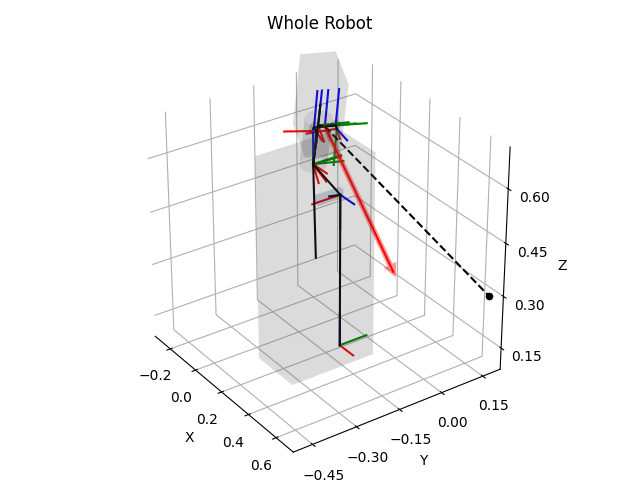

In [36]:
# Plotting
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in('world', whitelist=["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)
ax = tm.plot_visuals("world", alpha=0.1)

# Head Vector
T_ew = tm.get_transform('eyes','world')
x_ew = (T_ew @ np.array([1.0, 0, 0, 1.0]).reshape(-1,1)).squeeze()
plot_vector(
    start=np.array([T_ew[0,3], T_ew[1,3], T_ew[2,3]]),
    direction=np.array([x_ew[0]-T_ew[0,3], x_ew[1]-T_ew[1,3], x_ew[2]-T_ew[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='red',
    alpha=0.4
)
ax.plot([T_ew[0,3],x_ew[0]],[T_ew[1,3],x_ew[1]],[T_ew[2,3],x_ew[2]], color='red')

# Target Vector
T_cw = tm.get_transform('realsense','world')
x_cw_t = (T_cw @ np.array([x_c_t[0], x_c_t[1], x_c_t[2], 1.0]).reshape(-1,1)).squeeze()
ax.plot([T_ew[0,3],x_cw_t[0]],[T_ew[1,3],x_cw_t[1]],[T_ew[2,3],x_cw_t[2]], '--', color='black')
ax.scatter([x_cw_t[0]],[x_cw_t[1]],[x_cw_t[2]], color='black')

ax.view_init(elev=30, azim=-35, roll=0)
ax.set_xlim([-0.3, 0.7])
ax.set_ylim([-0.5, 0.2])
ax.set_zlim([0.1, 0.7])
ax.set_title('Whole Robot')
plt.tight_layout()

# Getting the angle between head vector and target
v_e = np.array([x_ew[0]-T_ew[0,3], x_ew[1]-T_ew[1,3], x_ew[2]-T_ew[2,3]])
v_t = np.array([x_cw_t[0]-T_ew[0,3], x_cw_t[1]-T_ew[1,3], x_cw_t[2]-T_ew[2,3]])
head_diff = math.acos((v_e @ v_t)/(np.linalg.norm(v_e)*np.linalg.norm(v_t)))
print('head_diff_angle (rad):', head_diff)
print('head_diff_angle (deg):', math.degrees(head_diff))

## Cost Function

In [37]:
def head_cost(X, V, x_c, y_c, z_c):
    # Target Point
    x_c_t = np.array([x_c,y_c,z_c])  # x,y,z
    
    # Input (deg)
    in_cmd_lnt = X[0]
    in_cmd_lnp = X[1]
    in_cmd_unt = X[2]
    in_cmd_et = 0
    in_cmd_lep = 0
    in_cmd_rep = 0

    # if cmd_unt > (-10 + 1e-2):  # To have seamless upper neck and lower neck integration
    #     cmd_lnt = 0

    # Input (rad)
    cmd_lnt = math.radians(in_cmd_lnt)
    cmd_lnp = math.radians(in_cmd_lnp)
    cmd_unt = math.radians(in_cmd_unt)
    cmd_et = math.radians(in_cmd_et)
    cmd_lep = math.radians(in_cmd_lep)
    cmd_rep = math.radians(in_cmd_rep)

    # Motor-to-Joint Mapping
    neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
    neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
    head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
    eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
    lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
    righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

    # Setting Motor Joints
    tm.set_joint('neck_pitch', neck_pitch)
    tm.set_joint('neck_yaw', neck_yaw)
    tm.set_joint('head_pitch', head_pitch)
    tm.set_joint('eyes_pitch', eyes_pitch)
    tm.set_joint('lefteye_yaw', lefteye_yaw)
    tm.set_joint('righteye_yaw', righteye_yaw)
    
    # Head Vector
    x_ee = np.array([1.0, 0, 0, 1.0])
    v_ee = np.array([1.0, 0, 0])
    
    # Target Vector
    T_ce = tm.get_transform('realsense','eyes')
    x_ce_t = (T_ce @ np.array([x_c_t[0], x_c_t[1], x_c_t[2], 1.0]).reshape(-1,1)).squeeze()
    v_ce_t = np.array([x_ce_t[0], x_ce_t[1], x_ce_t[2]])
    
    # Loss
    cost = 1 - (v_ee @ v_ce_t)/np.linalg.norm(v_ce_t)
    
    return cost

## Optimization

In [38]:
x_t = 0
y_t = 0
z_t = 1
X = np.array([0,0,0])

In [39]:
start = time.time()
opt = minimize(head_cost, X, 
               args=(V, x_t, y_t, z_t), method="Powell", 
               options={"disp":True},
               bounds=((-10,30),(-35,35),(-10,40)))
end = time.time()
print('Elapsed Time:', end-start)
print(opt.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 151
Elapsed Time: 0.17723941802978516
[24.48599733 -4.00517806 -0.04213274]


v_ee: [1. 0. 0.]
v_ce: [ 1.00229903e+00 -9.02167593e-09 -1.86656890e-09]
head_diff_angle (rad): 0.0
head_diff_angle (deg): 0.0


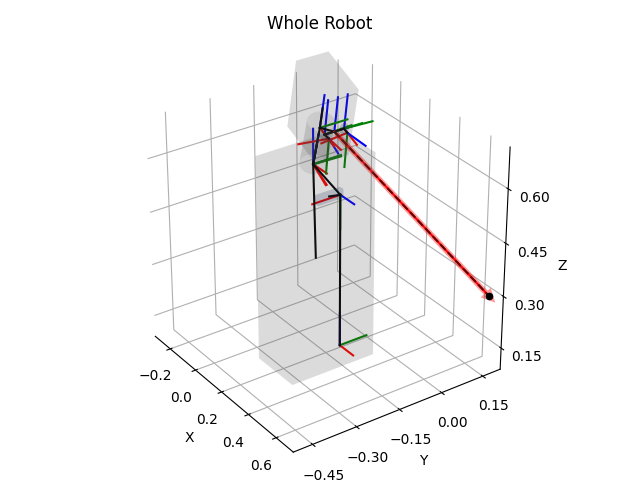

In [40]:
# Target Point
x_c_t = np.array([x_t,y_t,z_t])  # x,y,z

# Input (deg)
in_cmd_lnt = opt.x[0]
in_cmd_lnp = opt.x[1]
in_cmd_unt = opt.x[2]
in_cmd_et = 0
in_cmd_lep = 0
in_cmd_rep = 0

# Input (rad)
cmd_lnt = math.radians(in_cmd_lnt)  # Input (rad)lnt)
cmd_lnp = math.radians(in_cmd_lnp)
cmd_unt = math.radians(in_cmd_unt)
cmd_et = math.radians(in_cmd_et)
cmd_lep = math.radians(in_cmd_lep)
cmd_rep = math.radians(in_cmd_rep)

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)

# Head Vector
x_ee = np.array([1.0, 0, 0, 1.0])
v_ee = np.array([1.0, 0, 0])
print('v_ee:',v_ee)

# Target Vector
T_ce = tm.get_transform('realsense','eyes')
x_ce_t = (T_ce @ np.array([x_c_t[0], x_c_t[1], x_c_t[2], 1.0]).reshape(-1,1)).squeeze()
v_ce_t = np.array([x_ce_t[0], x_ce_t[1], x_ce_t[2]])
print('v_ce:',v_ce_t)

# Plotting
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in('world', whitelist=["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)
ax = tm.plot_visuals("world", alpha=0.1)

# Head Vector
T_ew = tm.get_transform('eyes','world')
x_ew = (T_ew @ np.array([1.0, 0, 0, 1.0]).reshape(-1,1)).squeeze()
plot_vector(
    start=np.array([T_ew[0,3], T_ew[1,3], T_ew[2,3]]),
    direction=np.array([x_ew[0]-T_ew[0,3], x_ew[1]-T_ew[1,3], x_ew[2]-T_ew[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='red',
    alpha=0.4
)
ax.plot([T_ew[0,3],x_ew[0]],[T_ew[1,3],x_ew[1]],[T_ew[2,3],x_ew[2]], color='red')

# Target Vector
T_cw = tm.get_transform('realsense','world')
x_cw_t = (T_cw @ np.array([x_c_t[0], x_c_t[1], x_c_t[2], 1.0]).reshape(-1,1)).squeeze()
ax.plot([T_ew[0,3],x_cw_t[0]],[T_ew[1,3],x_cw_t[1]],[T_ew[2,3],x_cw_t[2]], '--', color='black')
ax.scatter([x_cw_t[0]],[x_cw_t[1]],[x_cw_t[2]], color='black')

ax.view_init(elev=30, azim=-35, roll=0)
ax.set_xlim([-0.3, 0.7])
ax.set_ylim([-0.5, 0.2])
ax.set_zlim([0.1, 0.7])
ax.set_title('Whole Robot')
plt.tight_layout()

# Getting the angle between head vector and target
head_diff = math.acos((v_ee @ v_ce_t)/(np.linalg.norm(v_ce_t)))
print('head_diff_angle (rad):', head_diff)
print('head_diff_angle (deg):', math.degrees(head_diff))

# Inverse Kinematics Eyes

## Cost Function

In [41]:
def eyes_cost(X, V, x_c, y_c, z_c, in_cmd_lnt, in_cmd_lnp, in_cmd_unt):
    # Target Point
    x_c_t = np.array([x_c,y_c,z_c])  # x,y,z
    
    # Input (deg)
    in_cmd_et = X[0]
    in_cmd_lep = X[1]
    in_cmd_rep = X[2]

    # if cmd_unt > (-10 + 1e-2):  # To have seamless upper neck and lower neck integration
    #     cmd_lnt = 0

    # Input (rad)
    cmd_lnt = math.radians(in_cmd_lnt)
    cmd_lnp = math.radians(in_cmd_lnp)
    cmd_unt = math.radians(in_cmd_unt)
    cmd_et = math.radians(in_cmd_et)
    cmd_lep = math.radians(in_cmd_lep)
    cmd_rep = math.radians(in_cmd_rep)

    # Motor-to-Joint Mapping
    neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
    neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
    head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
    eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
    lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
    righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

    # Setting Motor Joints
    tm.set_joint('neck_pitch', neck_pitch)
    tm.set_joint('neck_yaw', neck_yaw)
    tm.set_joint('head_pitch', head_pitch)
    tm.set_joint('eyes_pitch', eyes_pitch)
    tm.set_joint('lefteye_yaw', lefteye_yaw)
    tm.set_joint('righteye_yaw', righteye_yaw)
    
    # Left Eye Vector
    x_ll = np.array([1.0, 0, 0, 1.0])
    v_ll = np.array([1.0, 0, 0])
    # Left Target Vector
    T_cl = tm.get_transform('realsense','lefteye')
    x_cl_t = (T_cl @ np.array([x_c_t[0], x_c_t[1], x_c_t[2], 1.0]).reshape(-1,1)).squeeze()
    v_cl_t = np.array([x_cl_t[0], x_cl_t[1], x_cl_t[2]])
    
    # Right Eye Vector
    x_rr = np.array([1.0, 0, 0, 1.0])
    v_rr = np.array([1.0, 0, 0])
    # Right Target Vector
    T_cr = tm.get_transform('realsense','righteye')
    x_cr_t = (T_cr @ np.array([x_c_t[0], x_c_t[1], x_c_t[2], 1.0]).reshape(-1,1)).squeeze()
    v_cr_t = np.array([x_cr_t[0], x_cr_t[1], x_cr_t[2]])
    
    # Loss
    cost = 2 - (v_ll @ v_cl_t)/np.linalg.norm(v_cl_t) - (v_rr @ v_cr_t)/np.linalg.norm(v_cr_t)
    
    return cost

## Optimization

In [42]:
# Input
x_t = 0.5
y_t = -0.2
z_t = 1.0
in_cmd_lnt = 10
in_cmd_lnp = 15
in_cmd_unt = 0
X = np.array([0,0,0])  # et, lep, rep

In [43]:
start = time.time()
opt = minimize(eyes_cost, X, 
               args=(V, x_t, y_t, z_t,in_cmd_lnt,in_cmd_lnp,in_cmd_unt), method="Powell", 
               options={"disp":True},
               bounds=((-30,20),(-14,14),(-14,14)))
end = time.time()
print('Elapsed Time:', end-start)
print(opt.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 46
Elapsed Time: 0.0854940414428711
[5.82718377 5.12980471 6.92678564]


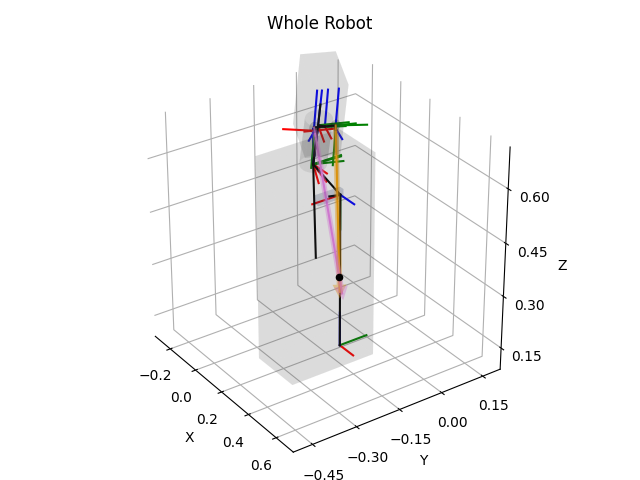

In [44]:
# Target Point
x_c_t = np.array([x_t,y_t,z_t])  # x,y,z

# Input (deg)
in_cmd_et = opt.x[0]
in_cmd_lep = opt.x[1]
in_cmd_rep = opt.x[2]

# Input (rad)
cmd_lnt = math.radians(in_cmd_lnt)  # Input (rad)lnt)
cmd_lnp = math.radians(in_cmd_lnp)
cmd_unt = math.radians(in_cmd_unt)
cmd_et = math.radians(in_cmd_et)
cmd_lep = math.radians(in_cmd_lep)
cmd_rep = math.radians(in_cmd_rep)

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)


# Plotting
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in('world', whitelist=["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)
ax = tm.plot_visuals("world", alpha=0.1)

# Left Gaze from Left Eye
T_lw = tm.get_transform('lefteye','world')
x_lw = (T_lw @ np.array([1.2, 0, 0, 1.0]).reshape(-1,1)).squeeze()
plot_vector(
    start=np.array([T_lw[0,3], T_lw[1,3], T_lw[2,3]]),
    direction=np.array([x_lw[0]-T_lw[0,3], x_lw[1]-T_lw[1,3], x_lw[2]-T_lw[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='orange',
    alpha=0.4
)
ax.plot([T_lw[0,3],x_lw[0]],[T_lw[1,3],x_lw[1]],[T_lw[2,3],x_lw[2]], color='orange')

# Right Gaze from Right Eye
T_rw = tm.get_transform('righteye','world')
x_rw = (T_rw @ np.array([1.2, 0, 0, 1.0]).reshape(-1,1)).squeeze()
plot_vector(
    start=np.array([T_rw[0,3], T_rw[1,3], T_rw[2,3]]),
    direction=np.array([x_rw[0]-T_rw[0,3], x_rw[1]-T_rw[1,3], x_rw[2]-T_rw[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='violet',
    alpha=0.4
)
ax.plot([T_rw[0,3],x_rw[0]],[T_rw[1,3],x_rw[1]],[T_rw[2,3],x_rw[2]], color='violet')

# Target
T_cw = tm.get_transform('realsense','world')
x_c_t = np.array([x_t,y_t,z_t])  # x,y,z
x_cw_t = (T_cw @ np.array([x_c_t[0], x_c_t[1], x_c_t[2], 1.0]).reshape(-1,1)).squeeze()
ax.scatter([x_cw_t[0]],[x_cw_t[1]],[x_cw_t[2]], color='black')

ax.view_init(elev=30, azim=-35, roll=0)
ax.set_xlim([-0.3, 0.7])
ax.set_ylim([-0.5, 0.2])
ax.set_zlim([0.1, 0.7])
ax.set_title('Whole Robot')
plt.tight_layout()

# Chest FOV Range Limit

In [45]:
class ExpChArucoAttention(object):

    def __init__(self, square_length=0.136, marker_length=0.091) -> None:
        self.chess_squares = (15, 8)
        self.square_length = square_length  # [Sweep] 19.4 cm, [Eval] 9.557 cm
        self.marker_length = marker_length  # [Sweep] 15 cm, [Eval] 7.436 cm        
        self.dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_100)
        self.parameters = aruco.DetectorParameters()
        self.parameters.cornerRefinementMethod = aruco.CORNER_REFINE_SUBPIX
        self.board = aruco.CharucoBoard(self.chess_squares, self.square_length, self.marker_length, self.dictionary)
        self.criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        self.charuco_detector = aruco.CharucoDetector(self.board)

# Instantiate Class
attention = ExpChArucoAttention()

In [46]:
def get_charuco_camera_pose(img, camera_mtx, dist_coef):
    charuco_corners, charuco_ids, marker_corners, marker_ids = attention.charuco_detector.detectBoard(img)
    if not (charuco_ids is None) and len(charuco_ids) >= 4:
        try:
            obj_points, img_points = attention.board.matchImagePoints(charuco_corners, charuco_ids)
            flag, rvec, tvec = cv2.solvePnP(obj_points, img_points, camera_mtx, dist_coef)

            # Convert the rotation vector to a rotation matrix
            rotation_matrix, _ = cv2.Rodrigues(rvec)
    
            # Homogeneous Coordinates (H = Tbc =T_board2cam)
            T = np.eye(4)
            T[:3,:3] = rotation_matrix
            T[:3,-1] = tvec.T
        
        except cv2.error as error_inst:
            print("SolvePnP recognize calibration pattern as non-planar pattern. To process this need to use "
                  "minimum 6 points. The planar pattern may be mistaken for non-planar if the pattern is "
                  "deformed or incorrect camera parameters are used.")
            print(error_inst.err)
            T = None
    else:
        T = None

    return T


## Read Images

In [47]:
img_1m = cv2.imread(os.path.join(os.getcwd(),"..","data","target_img","chest_target_1m.png"))
img_1pt25m = cv2.imread(os.path.join(os.getcwd(),"..","data","target_img","chest_target_1pt25m.png"))
img_1pt5m = cv2.imread(os.path.join(os.getcwd(),"..","data","target_img","chest_target_1pt5m.png"))

## Single Pass

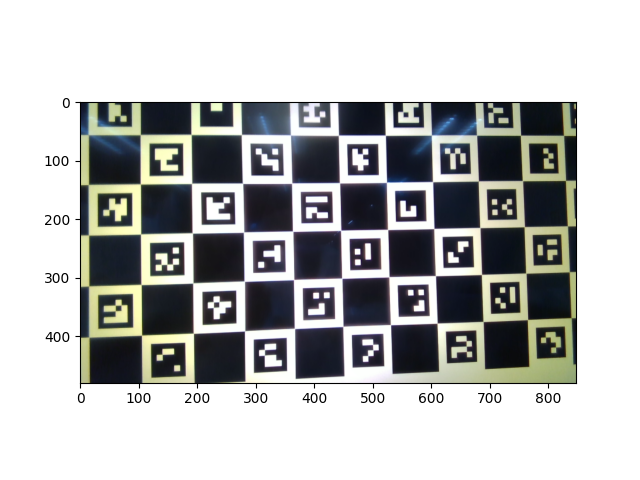

In [48]:
plt.figure()
plt.imshow(img_1m)

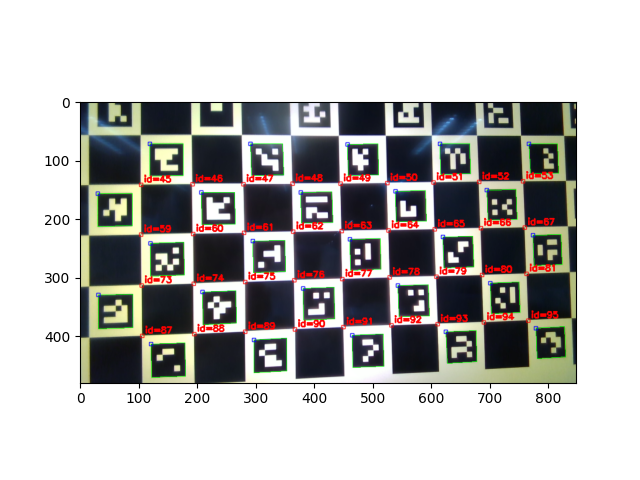

In [49]:
# Charuco and Marker Detection

# Input
image_copy = np.copy(img_1m)
camera_mtx = np.array(cam_mtxs['chest_cam']['camera_matrix'])
dist_coef = np.array(cam_mtxs['chest_cam']['distortion_coefficients'])

# Function
charuco_corners, charuco_ids, marker_corners, marker_ids = attention.charuco_detector.detectBoard(image_copy)
if not (marker_ids is None) and len(marker_ids) > 0:
    aruco.drawDetectedMarkers(image_copy, marker_corners)
if not (charuco_ids is None) and len(charuco_ids) > 0:
    aruco.drawDetectedCornersCharuco(image_copy, charuco_corners, charuco_ids)
    if len(camera_mtx) > 0 and len(charuco_ids) >= 4:
        try:
            obj_points, img_points = attention.board.matchImagePoints(charuco_corners, charuco_ids)
            flag, rvec, tvec = cv2.solvePnP(obj_points, img_points, camera_mtx, dist_coef)
            if flag:
                cv2.drawFrameAxes(image_copy, camera_mtx, dist_coef, rvec, tvec, .2)
                
                # Convert the rotation vector to a rotation matrix
                rotation_matrix, _ = cv2.Rodrigues(rvec)

                # Homogeneous Coordinates (H = Tbc =T_board2cam)
                T = np.eye(4)
                T[:3,:3] = rotation_matrix
                T[:3,-1] = tvec.T
            
        except cv2.error as error_inst:
            print("SolvePnP recognize calibration pattern as non-planar pattern. To process this need to use "
                  "minimum 6 points. The planar pattern may be mistaken for non-planar if the pattern is "
                  "deformed or incorrect camera parameters are used.")
            print(error_inst.err)
            T = None
plt.figure()
plt.imshow(image_copy)

In [50]:
# Mapping
charuco_id2pts = dict(zip(charuco_ids.flatten(),obj_points.squeeze()))
charuco_id2pts

{45: array([0.544, 0.544, 0.   ], dtype=float32),
 46: array([0.68000007, 0.544     , 0.        ], dtype=float32),
 47: array([0.81600004, 0.544     , 0.        ], dtype=float32),
 48: array([0.952, 0.544, 0.   ], dtype=float32),
 49: array([1.088, 0.544, 0.   ], dtype=float32),
 50: array([1.2240001, 0.544    , 0.       ], dtype=float32),
 51: array([1.3600001, 0.544    , 0.       ], dtype=float32),
 52: array([1.496, 0.544, 0.   ], dtype=float32),
 53: array([1.6320001, 0.544    , 0.       ], dtype=float32),
 59: array([0.544     , 0.68000007, 0.        ], dtype=float32),
 60: array([0.68000007, 0.68000007, 0.        ], dtype=float32),
 61: array([0.81600004, 0.68000007, 0.        ], dtype=float32),
 62: array([0.952     , 0.68000007, 0.        ], dtype=float32),
 63: array([1.088     , 0.68000007, 0.        ], dtype=float32),
 64: array([1.2240001 , 0.68000007, 0.        ], dtype=float32),
 65: array([1.3600001 , 0.68000007, 0.        ], dtype=float32),
 66: array([1.496     , 0.680

In [51]:
# Defined Targets
charuco_targets = [62,63,
                   76,77,]

charuco_targets

[62, 63, 76, 77]

In [52]:
# Get Projections

T_bc = T

proj_pts_list = []
for x in charuco_targets:
    proj_pts = T_bc @ np.array([charuco_id2pts[x][0],charuco_id2pts[x][1],0,1])
    proj_pts_list.append(proj_pts)

print('T_bc:', T_bc)
print('proj_pts_list:', proj_pts_list)

T_bc: [[ 0.99664778  0.02347275 -0.07837244 -1.06598783]
 [-0.02133916  0.99938149  0.02795122 -0.69258551]
 [ 0.07898005 -0.02618512  0.99653223  0.92651322]
 [ 0.          0.          0.          1.        ]]
proj_pts_list: [array([-0.10121766, -0.03332091,  0.98389635,  1.        ]), array([ 0.03432648, -0.03622304,  0.99463764,  1.        ]), array([-0.09802536,  0.10259495,  0.98033518,  1.        ]), array([0.03751877, 0.09969282, 0.99107647, 1.        ])]


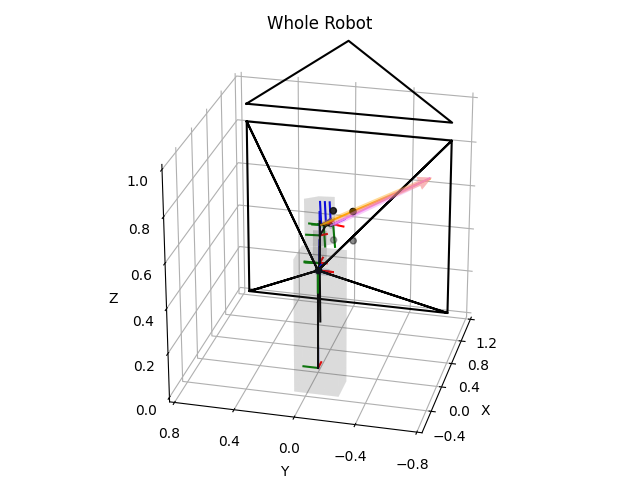

In [53]:
# Plotting

plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in('world', whitelist=["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)
ax = tm.plot_visuals("world", alpha=0.1)

# Charuco Targets
T_cw = tm.get_transform('realsense','world')
plot_pts_list = []
for x in proj_pts_list:
    plot_pts = T_cw @ x
    plot_pts_list.append(plot_pts[:3])
plot_pts_arr = np.array(plot_pts_list)
ax.scatter(plot_pts_arr[:,0],plot_pts_arr[:,1],plot_pts_arr[:,2], color='black')

# Left Gaze from Left Eye
T_lw = tm.get_transform('lefteye','world')
x_lw = (T_lw @ np.array([1.2, 0, 0, 1.0]).reshape(-1,1)).squeeze()
plot_vector(
    start=np.array([T_lw[0,3], T_lw[1,3], T_lw[2,3]]),
    direction=np.array([x_lw[0]-T_lw[0,3], x_lw[1]-T_lw[1,3], x_lw[2]-T_lw[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='orange',
    alpha=0.4
)
ax.plot([T_lw[0,3],x_lw[0]],[T_lw[1,3],x_lw[1]],[T_lw[2,3],x_lw[2]], color='orange')

# Right Gaze from Right Eye
T_rw = tm.get_transform('righteye','world')
x_rw = (T_rw @ np.array([1.2, 0, 0, 1.0]).reshape(-1,1)).squeeze()
plot_vector(
    start=np.array([T_rw[0,3], T_rw[1,3], T_rw[2,3]]),
    direction=np.array([x_rw[0]-T_rw[0,3], x_rw[1]-T_rw[1,3], x_rw[2]-T_rw[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='violet',
    alpha=0.4
)
ax.plot([T_rw[0,3],x_rw[0]],[T_rw[1,3],x_rw[1]],[T_rw[2,3],x_rw[2]], color='violet')

# Chest Camera Plot
cam2world = tm.get_transform('realsense','world')
intrinsic_matrix = np.array(cam_mtxs['chest_cam']['camera_matrix'])
virtual_image_distance = 1.0
ax = pt.plot_transform(A2B=cam2world, s=0.1)
pc.plot_camera(
    ax, cam2world=cam2world, M=intrinsic_matrix, sensor_size=(848,480),
    virtual_image_distance=virtual_image_distance)

# Plot
ax.view_init(elev=25, azim=-166, roll=0)
ax.set_xlim([-0.7, 1.2])
ax.set_ylim([-0.8, 0.8])
ax.set_zlim([0, 1])
ax.set_title('Whole Robot')
plt.tight_layout()

## Function Prototype

In [54]:
def get_obj_pts_chest(img, camera_mtx, dist_coef):
    # Input
    image_copy = np.copy(img)
    
    # Function
    charuco_corners, charuco_ids, marker_corners, marker_ids = attention.charuco_detector.detectBoard(image_copy)
    if not (charuco_ids is None) and len(charuco_ids) > 0:
        if len(camera_mtx) > 0 and len(charuco_ids) >= 4:
            try:
                obj_points, img_points = attention.board.matchImagePoints(charuco_corners, charuco_ids)
                flag, rvec, tvec = cv2.solvePnP(obj_points, img_points, camera_mtx, dist_coef)
                if flag:
                    # Convert the rotation vector to a rotation matrix
                    rotation_matrix, _ = cv2.Rodrigues(rvec)

                    # Homogeneous Coordinates (H = Tbc =T_board2cam)
                    T = np.eye(4)
                    T[:3,:3] = rotation_matrix
                    T[:3,-1] = tvec.T

            except cv2.error as error_inst:
                print("SolvePnP recognize calibration pattern as non-planar pattern. To process this need to use "
                      "minimum 6 points. The planar pattern may be mistaken for non-planar if the pattern is "
                      "deformed or incorrect camera parameters are used.")
                print(error_inst.err)
                T = None
                
    # Mapping
    charuco_id2pts = dict(zip(charuco_ids.flatten(),obj_points.squeeze()))
    
    # Defined Targets
    charuco_targets = [62,63,
                       76,77]
    
    # Get Projections
    T_bc = T
    proj_pts_list = []
    for x in charuco_targets:
        proj_pts = T_bc @ np.array([charuco_id2pts[x][0],charuco_id2pts[x][1],0,1])
        proj_pts_list.append(proj_pts)
    
    return proj_pts_list

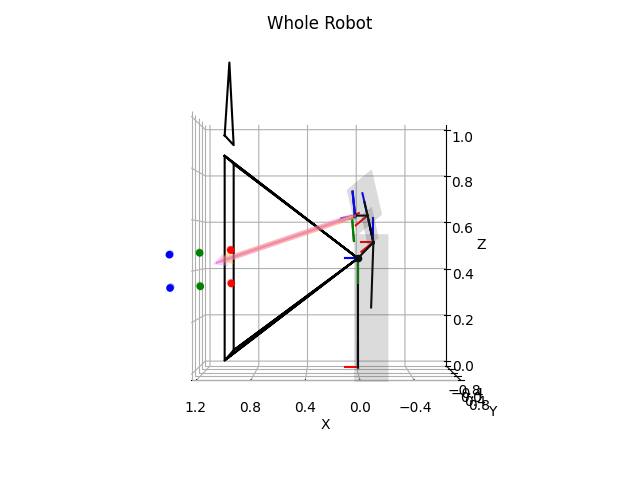

In [96]:
# Input (deg)
in_cmd_lnt = 30
in_cmd_lnp = 0
in_cmd_unt = -10
in_cmd_et = 20
in_cmd_lep = 14
in_cmd_rep = 14

# Input (rad)
cmd_lnt = math.radians(in_cmd_lnt)  # Input (rad)lnt)
cmd_lnp = math.radians(in_cmd_lnp)
cmd_unt = math.radians(in_cmd_unt)
cmd_et = math.radians(in_cmd_et)
cmd_lep = math.radians(in_cmd_lep)
cmd_rep = math.radians(in_cmd_rep)

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)

# Plotting

plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in('world', whitelist=["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)
ax = tm.plot_visuals("world", alpha=0.1)

# Charuco Targets (1m)
proj_pts_list = get_obj_pts_chest(img_1m, np.array(cam_mtxs['chest_cam']['camera_matrix']), np.array(cam_mtxs['chest_cam']['distortion_coefficients']))
T_cw = tm.get_transform('realsense','world')
plot_pts_list = []
for x in proj_pts_list:
    plot_pts = T_cw @ x
    plot_pts_list.append(plot_pts[:3])
plot_pts_arr = np.array(plot_pts_list)
ax.scatter(plot_pts_arr[:,0],plot_pts_arr[:,1],plot_pts_arr[:,2], color='red')

# Charuco Targets (1pt25m)
proj_pts_list = get_obj_pts_chest(img_1pt25m, np.array(cam_mtxs['chest_cam']['camera_matrix']), np.array(cam_mtxs['chest_cam']['distortion_coefficients']))
T_cw = tm.get_transform('realsense','world')
plot_pts_list = []
for x in proj_pts_list:
    plot_pts = T_cw @ x
    plot_pts_list.append(plot_pts[:3])
plot_pts_arr = np.array(plot_pts_list)
ax.scatter(plot_pts_arr[:,0],plot_pts_arr[:,1],plot_pts_arr[:,2], color='green')

# Charuco Targets (1pt5m)
proj_pts_list = get_obj_pts_chest(img_1pt5m, np.array(cam_mtxs['chest_cam']['camera_matrix']), np.array(cam_mtxs['chest_cam']['distortion_coefficients']))
T_cw = tm.get_transform('realsense','world')
plot_pts_list = []
for x in proj_pts_list:
    plot_pts = T_cw @ x
    plot_pts_list.append(plot_pts[:3])
plot_pts_arr = np.array(plot_pts_list)
ax.scatter(plot_pts_arr[:,0],plot_pts_arr[:,1],plot_pts_arr[:,2], color='blue')

# Left Gaze from Left Eye
T_lw = tm.get_transform('lefteye','world')
x_lw = (T_lw @ np.array([1.2, 0, 0, 1.0]).reshape(-1,1)).squeeze()
plot_vector(
    start=np.array([T_lw[0,3], T_lw[1,3], T_lw[2,3]]),
    direction=np.array([x_lw[0]-T_lw[0,3], x_lw[1]-T_lw[1,3], x_lw[2]-T_lw[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='orange',
    alpha=0.4
)
ax.plot([T_lw[0,3],x_lw[0]],[T_lw[1,3],x_lw[1]],[T_lw[2,3],x_lw[2]], color='orange')

# Right Gaze from Right Eye
T_rw = tm.get_transform('righteye','world')
x_rw = (T_rw @ np.array([1.2, 0, 0, 1.0]).reshape(-1,1)).squeeze()
plot_vector(
    start=np.array([T_rw[0,3], T_rw[1,3], T_rw[2,3]]),
    direction=np.array([x_rw[0]-T_rw[0,3], x_rw[1]-T_rw[1,3], x_rw[2]-T_rw[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='violet',
    alpha=0.4
)
ax.plot([T_rw[0,3],x_rw[0]],[T_rw[1,3],x_rw[1]],[T_rw[2,3],x_rw[2]], color='violet')

# Chest Camera Plot
cam2world = tm.get_transform('realsense','world')
intrinsic_matrix = np.array(cam_mtxs['chest_cam']['camera_matrix'])
virtual_image_distance = 1.0
ax = pt.plot_transform(A2B=cam2world, s=0.1)
pc.plot_camera(
    ax, cam2world=cam2world, M=intrinsic_matrix, sensor_size=(848,480),
    virtual_image_distance=virtual_image_distance)

# Plot
ax.view_init(elev=0, azim=90, roll=0)
ax.set_xlim([-0.7, 1.2])
ax.set_ylim([-0.8, 0.8])
ax.set_zlim([0, 1])
ax.set_title('Whole Robot')
plt.tight_layout()

# Generate Neck Limits

In [56]:
# Charuco Targets (1m)
proj_pts_list = get_obj_pts_chest(img_1m, np.array(cam_mtxs['chest_cam']['camera_matrix']), np.array(cam_mtxs['chest_cam']['distortion_coefficients']))
proj_pts_list

[array([-0.10121766, -0.03332091,  0.98389635,  1.        ]),
 array([ 0.03432648, -0.03622304,  0.99463764,  1.        ]),
 array([-0.09802536,  0.10259495,  0.98033518,  1.        ]),
 array([0.03751877, 0.09969282, 0.99107647, 1.        ])]

In [100]:
# List of Combinations
list_lnt=list(range(20,31,1))
list_lnp=list(range(-20,20,1))
list_unt=list(range(10,-11,-1))

# Combination
all_combi = np.array(list(itertools.product(list_lnt, list_lnp, list_unt)))
print(all_combi.shape)

(9240, 3)


In [101]:
# Initialize
X = np.array([0,0,0])  # et, lep, rep

# Optimization
start = time.time()

total_cost_list = []
idx_list = []
for idx,(in_cmd_lnt,in_cmd_lnp,in_cmd_unt) in enumerate(all_combi):
    print(idx)
    j = 0
    for j,proj_pts in enumerate(proj_pts_list):
        x_t = proj_pts[0]
        y_t = proj_pts[1]
        z_t = proj_pts[2]
        opt = minimize(eyes_cost, X, 
                       args=(V, x_t, y_t, z_t,in_cmd_lnt,in_cmd_lnp,in_cmd_unt), method="Powell",
                       bounds=((-30,20),(-14,14),(-14,14)))
        if opt.fun > 0:
            break
    if j==3:
        idx_list.append(idx)

end = time.time()
print('Elapsed Time:', end-start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [102]:
len(idx_list)

1949

In [103]:
test_lnt_list = []
test_lnp_list = []
test_unt_list = []
for idx in idx_list:
    lnt, lnp, unt = all_combi[idx]
    test_lnt_list.append(lnt)
    test_lnp_list.append(lnp)
    test_unt_list.append(unt)

test_df = pd.DataFrame({
    'cmd_theta_lower_neck_tilt': test_lnt_list,
    'cmd_theta_lower_neck_pan': test_lnp_list,
    'cmd_theta_upper_neck_tilt': test_unt_list,
})

test_df.to_csv(os.path.join(os.getcwd(),"..","data","neck_test","neck_test_cmd_1m.csv"), index=False)

In [104]:
test_df

,cmd_theta_lower_neck_tilt,cmd_theta_lower_neck_pan,cmd_theta_upper_neck_tilt
0,20,-20,-1
1,20,-20,-2
2,20,-17,6
3,20,-17,5
4,20,-16,9
...,...,...,...
1944,30,10,6
1945,30,10,5
1946,30,10,4
1947,30,13,7
